In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

# Load the CSV file containing image pairs and labels
csv_path = "COMP90086_2023_TLLdataset/train.csv"
data = pd.read_csv(csv_path)

# Path to the folder with images
image_folder = "COMP90086_2023_TLLdataset/train"

# Define the Siamese network architecture
def create_siamese_network(input_shape):
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (5, 5), activation='relu')(input_layer)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    encoded = layers.Lambda(lambda x: K.l2_normalize(x, axis=1))(x)  # L2-normalization

    return models.Model(inputs=input_layer, outputs=encoded)

# Create and compile the Siamese model
image_height = 245
image_width = 200
image_channels = 3
input_shape = (image_height, image_width, image_channels)
left_input = layers.Input(shape=input_shape)
right_input = layers.Input(shape=input_shape)

siamese_network = create_siamese_network(input_shape)

encoded_left = siamese_network(left_input)
encoded_right = siamese_network(right_input)

# Define the contrastive loss function
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    y_true = K.cast(y_true, 'float32')  # Cast y_true to float32
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


# Create the contrastive model
distance = layers.Lambda(lambda embeddings: K.abs(embeddings[0] - embeddings[1]))([encoded_left, encoded_right])
output = layers.Dense(1, activation='sigmoid')(distance)

contrastive_model = models.Model(inputs=[left_input, right_input], outputs=output)
contrastive_model.compile(loss=contrastive_loss, optimizer=Adam(0.0001))

# Prepare pairs of images and labels from the structured data in the CSV file
left_images = []
right_images = []
labels = []

for _, row in data.iterrows():
    left_image = tf.keras.preprocessing.image.load_img(
        f"{image_folder}/left/{row['left']}.jpg",
        target_size=(image_height, image_width)
    )
    left_image = tf.keras.preprocessing.image.img_to_array(left_image)
    left_image = left_image / 255.0  # Normalize pixel values

    right_image = tf.keras.preprocessing.image.load_img(
        f"{image_folder}/right/{row['right']}.jpg",
        target_size=(image_height, image_width)
    )
    right_image = tf.keras.preprocessing.image.img_to_array(right_image)
    right_image = right_image / 255.0  # Normalize pixel values

    left_images.append(left_image)
    right_images.append(right_image)
    labels.append(1)  # Similar pair (since these pairs look alike)

left_images = np.array(left_images)
right_images = np.array(right_images)
labels = np.array(labels)

# Train the Siamese network
contrastive_model.fit([left_images, right_images], labels, batch_size=32, epochs=10)

# Evaluate the model and use it for similarity comparison
def compute_similarity(image1, image2):
    # Load and preprocess the input images (you can use the same preprocessing as above)
    image1 = ...
    image2 = ...

    # Encode the images using the trained Siamese network
    encoded_image1 = siamese_network.predict(np.expand_dims(image1, axis=0))
    encoded_image2 = siamese_network.predict(np.expand_dims(image2, axis=0))

    # Compute the similarity score (e.g., cosine similarity or L2 distance) between the encoded vectors
    similarity_score = np.dot(encoded_image1, encoded_image2.T)

    return similarity_score


Epoch 1/10
63/63 [==============================] - 170s 3s/step - loss: 0.1541
Epoch 2/10
63/63 [==============================] - 192s 3s/step - loss: 0.0952
Epoch 3/10
63/63 [==============================] - 171s 3s/step - loss: 0.0779
Epoch 4/10
63/63 [==============================] - 187s 3s/step - loss: 0.0543
Epoch 5/10
63/63 [==============================] - 177s 3s/step - loss: 0.0353
Epoch 6/10
63/63 [==============================] - 180s 3s/step - loss: 0.0248
Epoch 7/10
63/63 [==============================] - 170s 3s/step - loss: 0.0193
Epoch 8/10
63/63 [==============================] - 172s 3s/step - loss: 0.0159
Epoch 9/10
63/63 [==============================] - 173s 3s/step - loss: 0.0137
Epoch 10/10
63/63 [==============================] - 182s 3s/step - loss: 0.0121


1/1 [==============================] - 0s 34ms/step


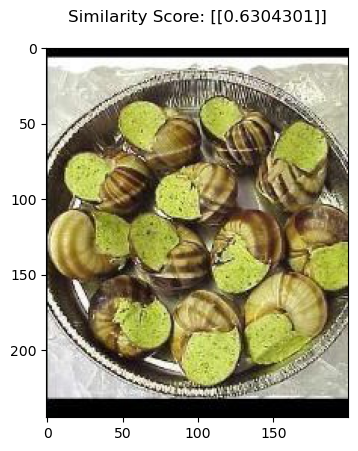

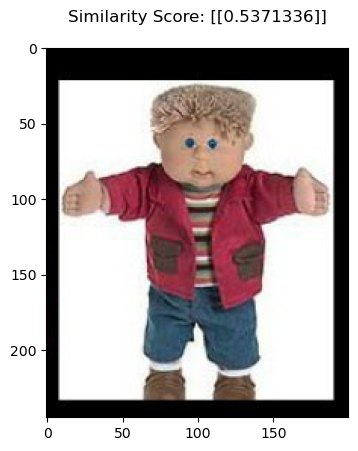

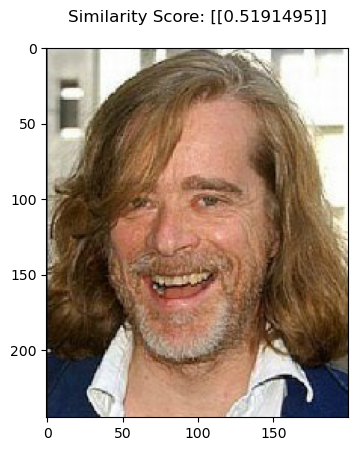

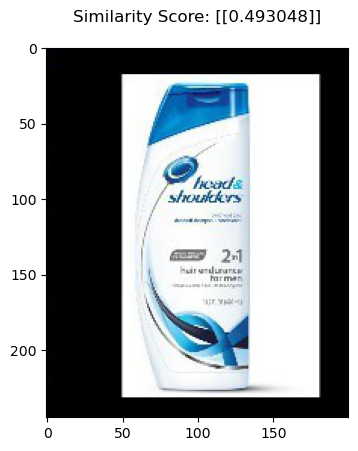

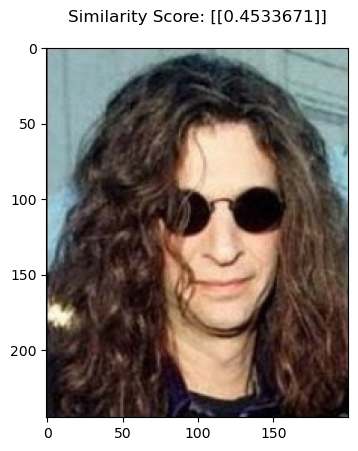

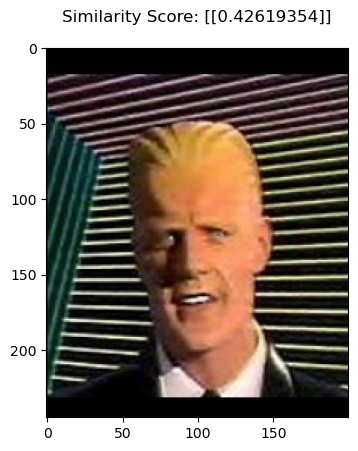

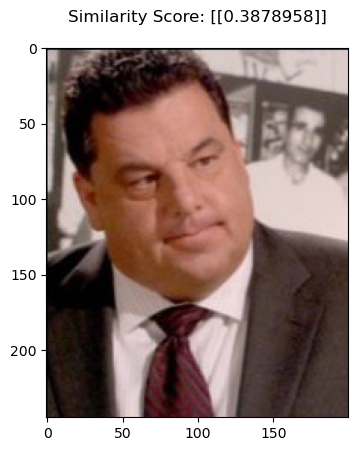

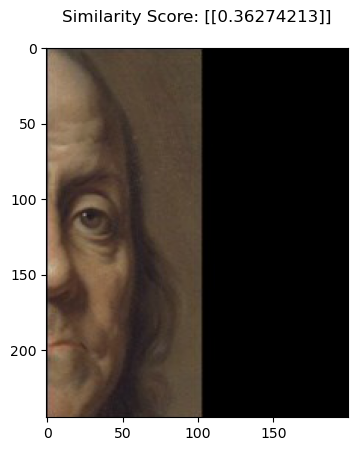

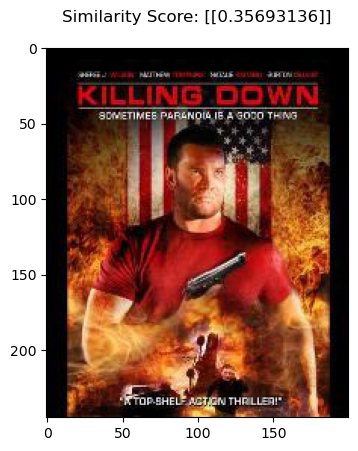

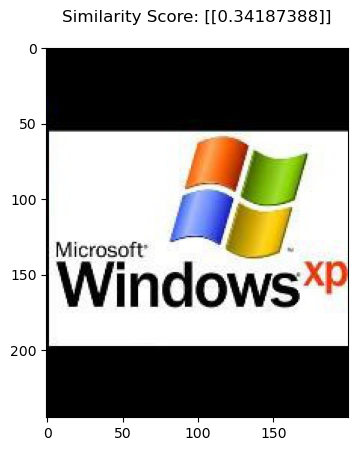

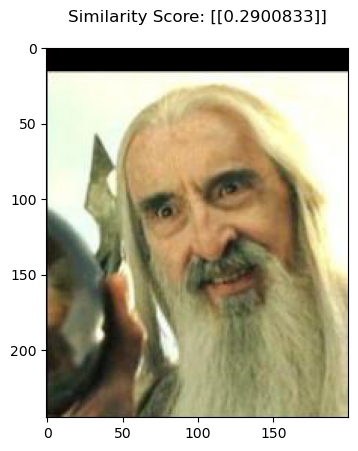

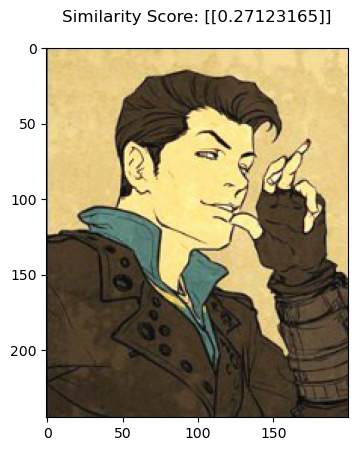

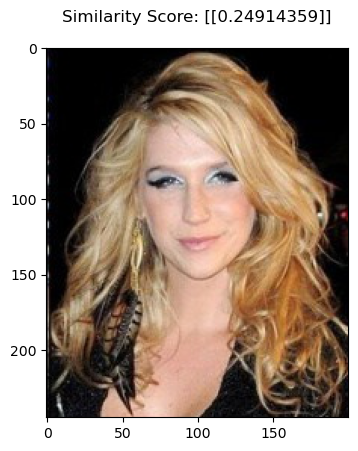

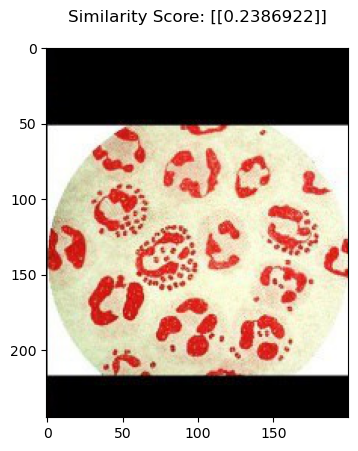

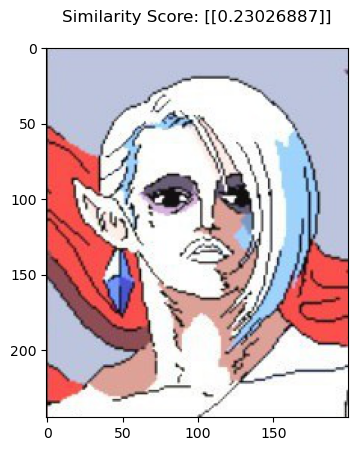

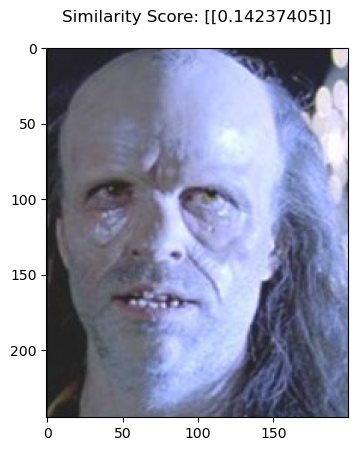

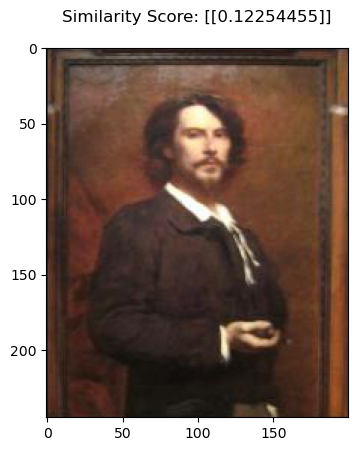

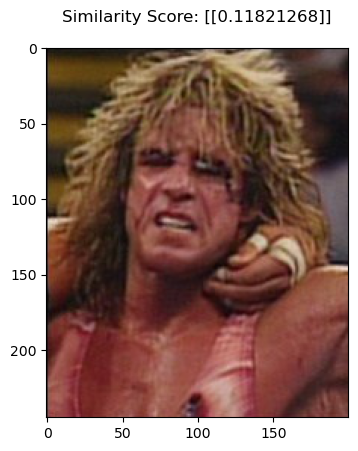

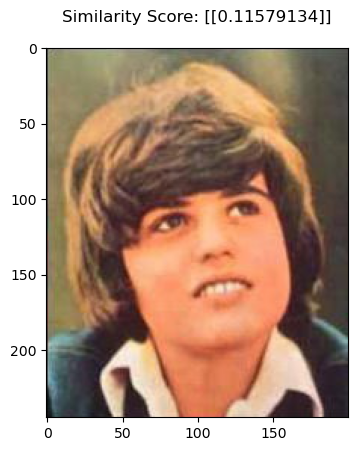

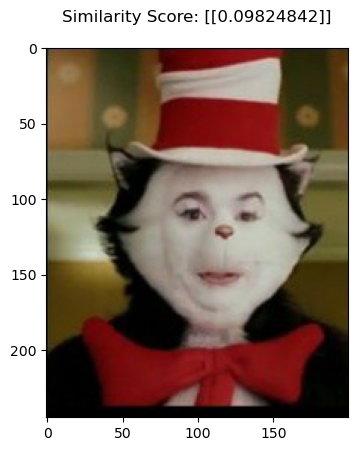

In [41]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Define a function to load and preprocess an image from its file path
def preprocess_image(image_path, target_size):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = image / 255.0  # Normalize pixel values
    return image

def compute_similarity(image1_path, image2_path, siamese_network):
    # Preprocess the input images
    input_shape = (245, 200, 3)
    image1 = preprocess_image(image1_path, input_shape[:2])
    image2 = preprocess_image(image2_path, input_shape[:2])

    # Encode the images using the trained Siamese network
    encoded_image1 = siamese_network.predict(np.expand_dims(image1, axis=0))
    encoded_image2 = siamese_network.predict(np.expand_dims(image2, axis=0))

    # Compute the similarity score (e.g., cosine similarity or L2 distance) between the encoded vectors
    similarity_score = np.dot(encoded_image1, encoded_image2.T)

    return similarity_score

# Load your trained Siamese model
input_shape = (245, 200, 3)
siamese_network = create_siamese_network(input_shape)
siamese_network.load_weights('siamese_model.h5')  # Load your trained weights

# Left input image
image1_path = "COMP90086_2023_TLLdataset/test/left/abm.jpg"

# List of right input images
right_image_paths = [
    "COMP90086_2023_TLLdataset/test/right/kyr.jpg",
    "COMP90086_2023_TLLdataset/test/right/qqo.jpg",
    "COMP90086_2023_TLLdataset/test/right/xpv.jpg",
    "COMP90086_2023_TLLdataset/test/right/tnd.jpg",
    "COMP90086_2023_TLLdataset/test/right/xal.jpg",
    "COMP90086_2023_TLLdataset/test/right/pvr.jpg",
    "COMP90086_2023_TLLdataset/test/right/nsb.jpg",
    "COMP90086_2023_TLLdataset/test/right/yzv.jpg",
    "COMP90086_2023_TLLdataset/test/right/ahb.jpg",
    "COMP90086_2023_TLLdataset/test/right/mlm.jpg",
    "COMP90086_2023_TLLdataset/test/right/drb.jpg",
    "COMP90086_2023_TLLdataset/test/right/vqu.jpg",
    "COMP90086_2023_TLLdataset/test/right/vzr.jpg",
    "COMP90086_2023_TLLdataset/test/right/kxe.jpg",
    "COMP90086_2023_TLLdataset/test/right/mdq.jpg",
    "COMP90086_2023_TLLdataset/test/right/oai.jpg",
    "COMP90086_2023_TLLdataset/test/right/nmm.jpg",
    "COMP90086_2023_TLLdataset/test/right/yzu.jpg",
    "COMP90086_2023_TLLdataset/test/right/ihk.jpg",
    "COMP90086_2023_TLLdataset/test/right/zwv.jpg",
]

# Compute and store similarity scores for all right images
similarity_scores = []
for image2_path in right_image_paths:
    similarity_score = compute_similarity(image1_path, image2_path, siamese_network)
    similarity_scores.append((image2_path, similarity_score))

# Sort the right images based on similarity scores
sorted_right_images = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

# Display the sorted right images with their similarity scores
for path, score in sorted_right_images:
    img = preprocess_image(path, input_shape[:2])
    plt.imshow(img)
    plt.title(f"Similarity Score: {score}\n")
    plt.show()
